In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'heartbeat:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F29414%2F37484%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240312%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240312T085329Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D14f9df328a9df3a0658692745fa768b4ac82e9f3b0a86e1d77a95252e981245334b183557c0b08db5d03280a5371b0a2dae28f8727d96c1d636482489108da4e5fcf7708f0367431fc8f631ff240960a62e88e651adb8fafc3ed15323e3021fb3b15e159bc02590481bf8456ce79f87e5d3c93fc704470bbc47be608a29c362cc46013166d773e9c0a6056b3b483f6a3058811a0d1606771262fa2c8372f74c16eba2c9a902f4e5b15e6c3cece8bb02e3c8b1f9043e7d8633e3c38f0c7e62da0dd40140c6940cd37570011aeb8c50ddd0ffb64f8673f7ab9f634f95ddeda01412ec73c81dc307f1365f14dba21737520e9d7b8fde175cbf1469939d277f635ea'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 103633768 bytes downloaded
Downloaded and uncompressed: heartbeat
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import StepLR

In [3]:
#load csv files to pandas dataframe
train_df = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv', header=None)

In [4]:
#the last column is the data label described as category from 0 to 4
#so we can use it as a target
y_df = train_df.iloc[:, -1]
y_df = y_df.astype('int')
y_df.head()

0    0
1    0
2    0
3    0
4    0
Name: 187, dtype: int64

In [5]:
#the rest are the ecg datapoints so we use them as features
X_df = train_df.iloc[:, :-1]
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#convert all feautures to float type
X_df = X_df.astype('float')
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#we actually dont need to one hot encode the target since we are using cross entropy loss and it runs more efficiently when we pass in the target as indices
#print out the unique values in the target
unique, counts = np.unique(y_df, return_counts=True)
print(f'unique values: {unique}')
print(f'counts: {counts}')

unique values: [0 1 2 3 4]
counts: [72471  2223  5788   641  6431]


In [8]:
#make a dictionary to map the target indices to class names
class_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

In [9]:
#the input dims are 187 and the output dims are 5
#we want the input to be (batch_size, 1, 187) and the output to be (batch_size, 5) because the input has one channel and the output has 5 classes
X_np = X_df.to_numpy()
X_np.shape

(87554, 187)

In [10]:
#we want to add a channel dimension to the input
X_np = X_np.reshape(-1, 1, 187)
X_np.shape

(87554, 1, 187)

In [11]:
#do the same for the target
y_np = y_df.to_numpy()
y_np.shape

(87554,)

In [12]:
y_np = y_np.reshape(-1, 1)
y_np.shape

(87554, 1)

In [13]:
#perfect, we now have the input and target in the correct shape
X_mean = X_np.mean()
X_std = X_np.std()
X_max = X_np.max()
X_min = X_np.min()
print(f'mean before normalization: {X_mean}')
print(f'std: {X_std}')
print(f'max: {X_max}')

mean before normalization: 0.17428295254906354
std: 0.22632738719052128
max: 1.0


In [14]:
#we need to subtract the mean from the data
X_norm = X_np - X_mean
#then multiply by 1/std to make the std = 1
X_norm *= 1/X_std

In [15]:
print(X_norm.shape)
print(f'new mean is {X_norm.mean()}')
print(f'new std is {X_norm.std()}')

(87554, 1, 187)
new mean is 1.5088439287128576e-15
new std is 1.0000000000000004


In [16]:
X_norm.shape #representing the input data as a sequence of 187 points

(87554, 1, 187)

In [17]:
y_np.shape #representing the target as indices 0 to 4

(87554, 1)

Saving the normalized variables

In [18]:
#saving the normalized data to a csv file
np.savetxt('X_norm.csv', X_norm.squeeze(), delimiter=',')
np.savetxt('y_np.csv', y_np, delimiter=',')
# np.loadtxt('X_norm.csv', delimiter=',').shape

Loading the normalized variables from disk

In [19]:
X_norm = np.loadtxt('X_norm.csv', delimiter=',').reshape(-1, 1, 187)
y_np = np.loadtxt('y_np.csv', delimiter=',').reshape(-1, 1)

In [20]:
print(X_norm.shape)
print(y_np.shape)

(87554, 1, 187)
(87554, 1)


In [21]:
#change y_np data type to int
y_np = y_np.astype('int')
y_np.dtype

dtype('int64')

split the data into training and validation sets using scikit-learn

In [22]:
#shuffle the data and split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_np, test_size=0.2, shuffle=True)

Now check for class imbalance

In [23]:
#print the frequency of each class in the train and validation sets
print(f'Frequency of each class in the train set')
unique, counts = np.unique(y_train, return_counts=True)
for i in range(len(unique)):
    print(f'{class_names[unique[i]]}: {counts[i]}')

print(f'Frequency of each class in the validation set')
unique, counts = np.unique(y_val, return_counts=True)
for i in range(len(unique)):
    print(f'{class_names[unique[i]]}: {counts[i]}')

Frequency of each class in the train set
N: 57965
S: 1764
V: 4656
F: 504
Q: 5154
Frequency of each class in the validation set
N: 14506
S: 459
V: 1132
F: 137
Q: 1277


define a hyper-parameters dictionary

In [24]:
hyper_params = {'bs': 1024,
                                'lr': 1e-3,
                                'lr_decay': 0.3,
                                'epochs':50,
                                }

In [25]:
#pytorch dataset and dataloader
train_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())

In [26]:
len(train_ds), len(val_ds)

(70043, 17511)

compute the weight of each class by inverting their distribution and normalizing it

In [27]:
#the class distribution is not uniform so we have to define weights for each class
class_dist = np.unique(y_train, return_counts=True)[1] #index 1 returns the counts
class_dist = class_dist/np.sum(class_dist) #normalize to get 0-1 values
# normalize the weights
weights = 1/class_dist #invert to compensate for class distribution imbalance
weights = weights/weights.sum() #normalize to get values 0-1
weights, class_names

(array([0.00579488, 0.19041973, 0.07214356, 0.66646906, 0.06517276]),
 {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'})

assign each example in the training set the weight we computed in the above cell

In [28]:
#get weights for each example in the dataset
data_weights = np.zeros(y_train.shape[0]) #shape (m, )
for i in range(y_train.shape[0]): #for each example we assign the corresponding weight
    data_weights[i] = weights[y_train[i, 0]]
data_weights[:10]

array([0.00579488, 0.00579488, 0.07214356, 0.00579488, 0.00579488,
       0.00579488, 0.00579488, 0.00579488, 0.00579488, 0.00579488])

pass the weights to the WeightedRandomSampler to sample according to the normalized weights

In [29]:
#data loader - we use the random weights sampler to balance the classes
train_dl = DataLoader(train_ds, batch_size=hyper_params['bs'], sampler=WeightedRandomSampler(weights=data_weights, num_samples= len(y_train), replacement=True))
val_dl = DataLoader(val_ds, batch_size=hyper_params['bs'])

check the training dataloader for class distributions

In [30]:
#get the class distribution in dataloader
for batch in train_dl:
    print(batch[1].shape)
    unique, counts = np.unique(batch[1], return_counts=True)
    for i in range(len(unique)):
        print(f'{class_names[unique[i]]}: {counts[i]}')
    break

torch.Size([1024, 1])
N: 216
S: 186
V: 221
F: 214
Q: 187


Network Architecture

In [31]:
#make some convolutional blocks to use in the model
def nin_block(in_channels, out_channels, kernel_size, padding, strides):
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, kernel_size, strides, padding),
        nn.BatchNorm1d(out_channels),
        nn.GELU(),
        nn.Conv1d(out_channels, out_channels, kernel_size=1), nn.GELU(),
        nn.Conv1d(out_channels, out_channels, kernel_size=1), nn.GELU()
    )

In [32]:
def get_model():
    return nn.Sequential( #input shape: (batch_size, 1, 187)
        nin_block(1, 48, kernel_size=11, strides=4, padding=0), #output shape: (batch_size, 48, 44)
        nn.MaxPool1d(3, stride=2), #output shape: (batch_size, 48, 21)
        nin_block(48, 128, kernel_size=5, strides=1, padding=2), #output shape: (batch_size, 128, 21)
        nn.MaxPool1d(3, stride=2), #output shape: (batch_size, 128, 10)
        nin_block(128, 256, kernel_size=3, strides=1, padding=1), #output shape: (batch_size, 256, 10)
        nn.MaxPool1d(3, stride=2), #output shape: (batch_size, 256, 4)
        nn.Dropout(0.4),
        #last layers for classification of 5 classes
        nin_block(256, 5, kernel_size=3, strides=1, padding=1), #output shape: (batch_size, 5, 4)
        nn.AdaptiveAvgPool1d(1), #output shape: (batch_size, 5, 1)
        nn.Flatten() #output shape: (batch_size, 5)
    )

In [33]:
model = get_model()

In [34]:
#model size in MB
print(f'Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)*4/(1024**2)} MB')
#number of trainable parameters
print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Model size: 1.1599540710449219 MB
Number of trainable parameters: 304075


In [35]:
#find device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [36]:
#move the model to the device
model = model.to(device)

In [37]:
class_names

{0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

In [38]:
#loss function
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1.1, 2.5, 3, 1], dtype=torch.float, device=device)) #CE loss automatically uses indices as targets

In [39]:
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=hyper_params['lr'])

In [40]:
#lr_scheduler
lr_scheduler = StepLR(optimizer, step_size=10, gamma=hyper_params['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [41]:
import matplotlib.pyplot as plt

def train(model, criterion, optimizer, train_dl, val_dl, epochs, lr_scheduler=None):
    train_losses = []
    val_losses = []
    train_accuracies = []  # To record training accuracy
    val_accuracies = []    # To record validation accuracy
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-'*10)
        train_loss = 0
        val_loss = 0
        model.train()  # set the model to training mode
        corrects_train = 0  # To calculate training accuracy
        total_train = 0
        for x, y in train_dl:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            # Calculate training accuracy
            _, preds_train = torch.max(output, 1)
            corrects_train += torch.sum(preds_train == y.squeeze()).item()
            total_train += y.size(0)
        train_accuracy = corrects_train / total_train
        train_accuracies.append(train_accuracy)
        train_loss = train_loss / len(train_dl.dataset)
        train_losses.append(train_loss)

        if lr_scheduler is not None:
            lr_scheduler.step()  # update the learning rate every n epochs

        model.eval()  # set the model to evaluation mode
        corrects_val = 0  # To calculate validation accuracy
        total_val = 0
        for x, y in val_dl:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = criterion(output, y.squeeze())
            val_loss += loss.item() * x.size(0)
            # Calculate validation accuracy
            _, preds_val = torch.max(output, 1)
            corrects_val += torch.sum(preds_val == y.squeeze()).item()
            total_val += y.size(0)
        val_accuracy = corrects_val / total_val
        val_accuracies.append(val_accuracy)
        val_loss = val_loss / len(val_dl.dataset)
        val_losses.append(val_loss)

        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t Val Accuracy: {val_accuracy:.4f}')

        # if the model performs better on the validation set, save the model parameters
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_params = deepcopy(model.state_dict())

    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    # Plot the training and validation accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curves')
    plt.legend()
    plt.show()

    return train_losses, val_losses, best_model_params, best_accuracy


Epoch 1/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.4236 	 Val Loss: 1.5033 	 Val Accuracy: 0.3733
Epoch 2/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.1559 	 Val Loss: 0.7082 	 Val Accuracy: 0.7978
Epoch 3/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.0043 	 Val Loss: 0.5479 	 Val Accuracy: 0.8171
Epoch 4/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.9071 	 Val Loss: 0.4800 	 Val Accuracy: 0.8365
Epoch 5/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.7536 	 Val Loss: 0.3415 	 Val Accuracy: 0.9449
Epoch 6/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.5516 	 Val Loss: 0.3012 	 Val Accuracy: 0.9407
Epoch 7/50
----------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.4245 	 Val Loss: 0.2879 	 Val Accuracy: 0.9241
Epoch 8/50
----------
Adjusting learning rate of group 0 to 1.0000e-0

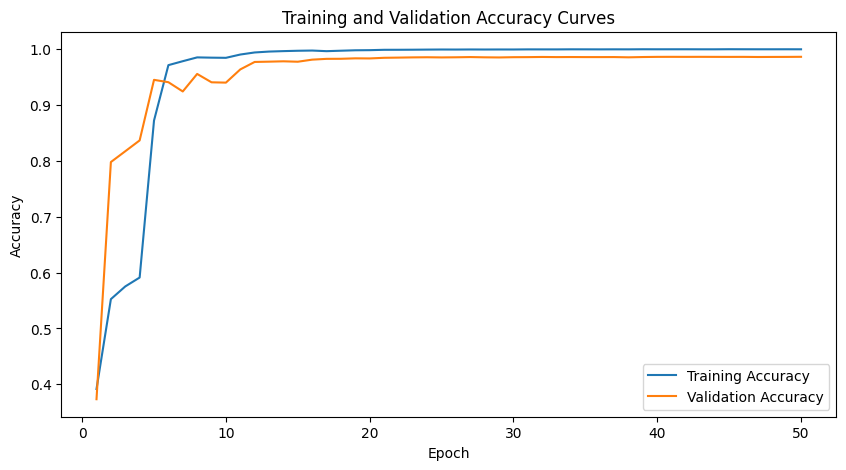

In [43]:
train_losses, val_losses, best_model_params, best_accuracy = train(model, criterion, optimizer, train_dl, val_dl, hyper_params['epochs'], lr_scheduler)

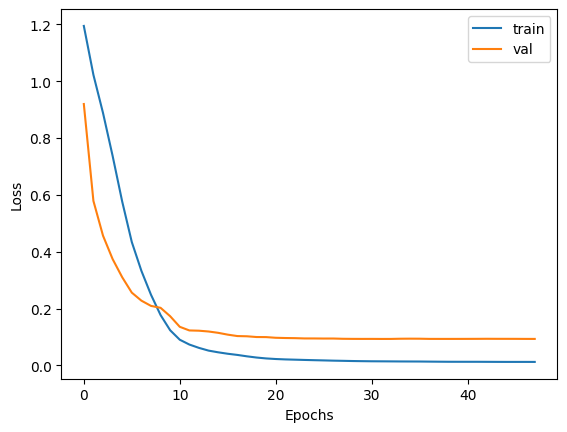

In [44]:
#plot the training and validation losses with smooth lines
plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [45]:
#load the best model parameters
model.load_state_dict(best_model_params)
#save the model to a file
torch.save(model.state_dict(), f'best_model{best_accuracy:.2f}.pt')

In [46]:
#use this cell to load weights from disk
model = get_model().to(device=device)
model.load_state_dict(torch.load('best_model0.99.pt'))

<All keys matched successfully>

In [47]:
#confusion matrix function
def plot_cm(model, dl, categories, normalize='true'):
    #plot the confusion matrix
    model.eval()
    y_pred = []
    y_true = []
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)
        output = model(x) #out shape: (batch_size, 5)
        y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())
        y_true.extend(y.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    sns.heatmap(cm, annot=True, fmt= '.2f', cmap='Blues', xticklabels=categories.values(), yticklabels=categories.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_true, y_pred, target_names=class_names.values()))

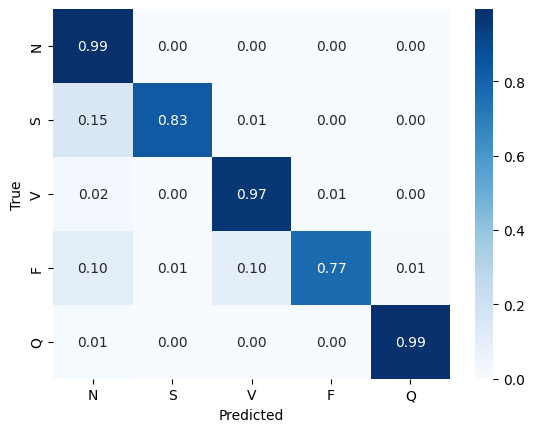

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     14506
           S       0.92      0.83      0.88       459
           V       0.96      0.97      0.96      1132
           F       0.85      0.77      0.81       137
           Q       0.99      0.99      0.99      1277

    accuracy                           0.99     17511
   macro avg       0.94      0.91      0.93     17511
weighted avg       0.99      0.99      0.99     17511



In [48]:
#plot the confusion matrix using the validation set
plot_cm(model, val_dl, class_names)